In [7]:
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

<h1> A 1. Implement 1D Convolution without using for loops. </h1>

<h5>
<p>
For this, I will be implementing 1D colvolution with the matrix-vector notation, that is, g = Hf. Where H is the filter represented as a circulant matrix known as a toeplitz matrix (but truncated to wrap around in order to mimic np.convolve) and f is a vector of the discrete amplitudes. 
</p>
<p>
Example: The way I would convolve filter: [3, 2, 1] against signal [5, 4, 7, 1, 9] would be as follows. <br>
First converting H into a matrix as such: <br>

H = <br>

<math>
  <mrow>
    <mo>[</mo>
    <mtable>
      <mtr>
        <mtd>
          <mn>1</mn>
        </mtd>
        <mtd>
          <mn>2</mn>
        </mtd>
        <mtd>
          <mn>3</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>                      
      </mtr>
      <mtr>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>1</mn>
        </mtd>
        <mtd>
          <mn>2</mn>
        </mtd>
        <mtd>
          <mn>3</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>                      
      </mtr>
      <mtr>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>1</mn>
        </mtd>
        <mtd>
          <mn>2</mn>
        </mtd>
        <mtd>
          <mn>3</mn>
        </mtd>                      
      </mtr>  
      <mtr>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>                      
      </mtr>
      <mtr>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>
        <mtd>
          <mn>0</mn>
        </mtd>                      
      </mtr>                
    </mtable>
    <mo>]</mo>
  </mrow>
</math>


f <sup> T = 

<br>
<math>
  <mrow>
    <mo>[</mo>
    <mtable>
      <mtr>
        <mtd>
          <mn>5</mn>
        </mtd>                     
      </mtr>
      <mtr>
        <mtd>
          <mn>4</mn>
        </mtd>                     
      </mtr>
      <mtr>
        <mtd>
          <mn>7</mn>
        </mtd>                    
      </mtr>
      <mtr>
        <mtd>
          <mn>1</mn>
        </mtd>                 
      </mtr>
      <mtr>
        <mtd>
          <mn>9</mn>
        </mtd>                   
      </mtr>                  
    </mtable>
    <mo>]</mo>
  </mrow>
</math>

After multiplying them, it is clearly equivalent to sliding the filter across the input one step at a time. 

</h5>


<i> <h4> For this question in particular I am using the procedure mentioned in this video: https://www.youtube.com/watch?v=W2_nD85jL5s . 
<br>
And in general, I am following the approach from this source: https://www.cs.uoi.gr/~cnikou/Courses/Digital_Image_Processing/2010-2011/Chapter_04c_Frequency_Filtering_(Circulant_Matrices)_2spp.pdf <br> 

I will continue to build on this when I introduce Doubly Block Toeplitz matrices for part B</h4></i>

In [8]:
#helper function to convert 1D filter into a circulant matrix
def createToeplitzMatrix(filter, input_len):
  filter = filter[::-1] #reverse the filter because np.convolve is weird and does it backwards
  filter_len = len(filter)
  output_len = input_len + filter_len - 1
  matrix = np.zeros((output_len, input_len))
  #fill the first row with the filter
  matrix[0, :filter_len] = filter
  # fill the remaining rows by shifting the filter to the right
  for i in range(output_len):
      row_start = max(0, i - (filter_len - 1))
      row_end = min(i + 1, input_len)
      
      filter_start = max(0, filter_len - (i + 1))
      filter_end = filter_len - max(0, i - (input_len - 1))
      
      matrix[i, row_start:row_end] = filter[filter_start:filter_end]
  
  return matrix

#convolution function
def oneDConvolution(input, filter):
  #create the filter matrix
  matrix = createToeplitzMatrix(filter, len(input))
  #multiply the matrix with the input
  return np.dot(matrix, input)

<h4>Let's see how the matrix of a random array would look</h4>

In [9]:
print("Toeplitz matrix test")
print(createToeplitzMatrix([1, 2, 3, 4], 8))

Toeplitz matrix test
[[1. 3. 2. 1. 0. 0. 0. 0.]
 [2. 1. 0. 0. 0. 0. 0. 0.]
 [3. 2. 1. 0. 0. 0. 0. 0.]
 [4. 3. 2. 1. 0. 0. 0. 0.]
 [0. 4. 3. 2. 1. 0. 0. 0.]
 [0. 0. 4. 3. 2. 1. 0. 0.]
 [0. 0. 0. 4. 3. 2. 1. 0.]
 [0. 0. 0. 0. 4. 3. 2. 1.]
 [0. 0. 0. 0. 0. 4. 3. 2.]
 [0. 0. 0. 0. 0. 0. 4. 3.]
 [0. 0. 0. 0. 0. 0. 0. 4.]]


The first row is storing the original vector, and I am starting the roll from the second row 

<h2> Let's compare my implementation against np.convolve </h2>

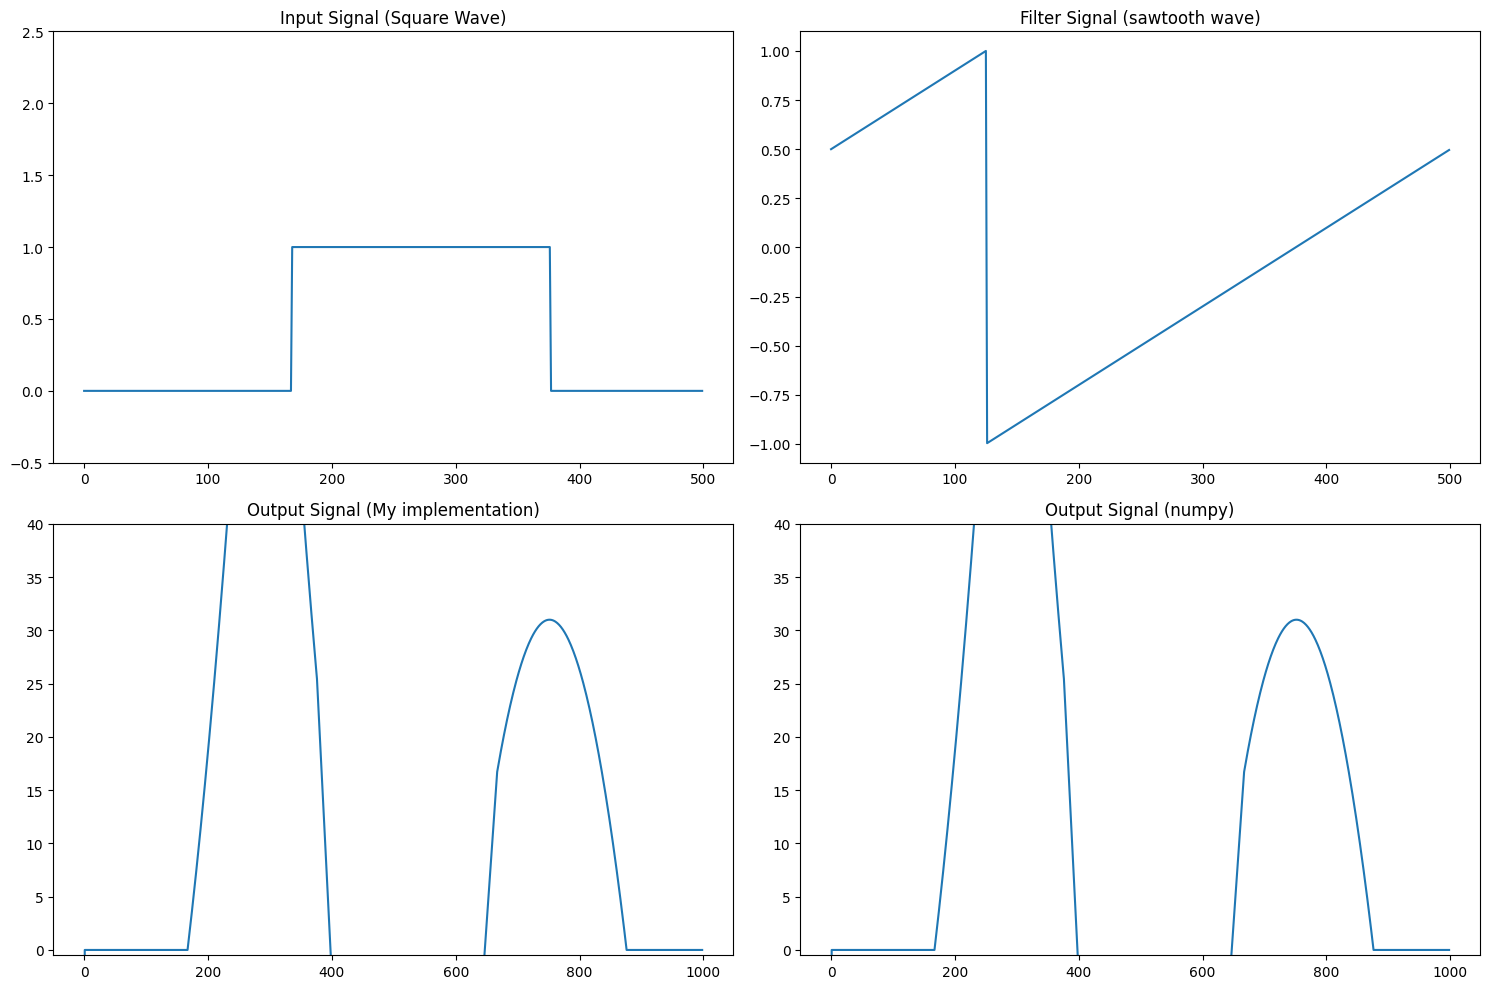

In [10]:
t = np.linspace(0.15, 0.35, 500, endpoint=False)

plt.figure(figsize=(15, 10))

#Input Signal
plt.subplot(2, 2, 1)
plt.ylim(-0.5, 2.5)
sig1 = signal.square(2 * np.pi * 5.99 * t + 4.4) + 1
sig1 = sig1 / 2
plt.title("Input Signal (Square Wave)")
plt.plot(sig1)

#Filter Signal
plt.subplot(2, 2, 2)
sigt = np.zeros_like(sig1)
sigt = signal.sawtooth(2 * np.pi * 5 * t)
plt.title("Filter Signal (sawtooth wave)")
plt.plot(sigt)

#Output Signal
plt.subplot(2, 2, 3)
plt.ylim(-0.5, 40)
# Assuming sig3 is the output signal
sig3 = oneDConvolution(sig1, sigt)
plt.title("Output Signal (My implementation)")
plt.plot(sig3)

#np.convolve Signal
plt.subplot(2, 2, 4)
plt.ylim(-0.5, 40)
# Assuming sig3 is the output signal
sig4 = np.convolve(sig1, sigt, "full")
plt.title("Output Signal (numpy)")
plt.plot(sig3)
plt.tight_layout()
plt.show()

<h3>Calculating accuracy using MSE</h3>

In [11]:
#calculating the mean squared error
np.mean((sig4 - sig3) ** 2)


np.float64(13.873755739739748)

<h3>Runtime Comparison</h3>

In [12]:
#large signal generation for runtime testing
def generate_large_signals(size):
    t = np.linspace(0, 1, size, endpoint=False)
    input_signal = signal.square(2 * np.pi * 5.99 * t + 4.4) + 1
    input_signal = input_signal / 2
    filter_signal = signal.sawtooth(2 * np.pi * 5 * t)
    return input_signal, filter_signal

def compare_runtime(signal_size):
    # Generate large input signals
    input_signal, filter_signal = generate_large_signals(signal_size)

    #runtime for custom oneDConvolution
    start_time = time.time()
    custom_output = oneDConvolution(input_signal, filter_signal)
    custom_time = time.time() - start_time

#runtime for np.convolve
    start_time = time.time()
    np_output = np.convolve(input_signal, filter_signal, mode='full')
    np_time = time.time() - start_time

    return custom_time, np_time

large_signal_size = 20000
custom_time, np_time = compare_runtime(large_signal_size)

print(f"Custom implementation runtime: {custom_time:.6f} seconds")
print(f"np.convolve runtime: {np_time:.6f} seconds")

Custom implementation runtime: 3.289886 seconds
np.convolve runtime: 0.081159 seconds


Some deeper run time analyses and accuracy comparisons with justifications are provided in later parts- which are still relevant to this.